In [1]:
from glob import glob
import os
import matplotlib.pyplot as plt
import cv2
from time import time

import tensorflow as tf
# tf.enable_eager_execution()
tf.VERSION

'1.13.1'

### Load data: Tiny Imagenet
**Train Data**: train_paths, train_labels  
**Validation Data**: val_paths, val_labels  

This output is common for any problem (classification, segmentation).

('Train data : ', 100000, 100000, 199, 0)
(['../data/tiny-imagenet-200/train/n02124075/images/n02124075_0.JPEG', '../data/tiny-imagenet-200/train/n02124075/images/n02124075_1.JPEG', '../data/tiny-imagenet-200/train/n02124075/images/n02124075_10.JPEG'], [0, 0, 0])


('Validation data : ', 10000, 10000, 199, 0)
(['../data/tiny-imagenet-200/val/images/val_0.JPEG', '../data/tiny-imagenet-200/val/images/val_1.JPEG', '../data/tiny-imagenet-200/val/images/val_10.JPEG'], [48, 138, 157])


(64, 64, 3)


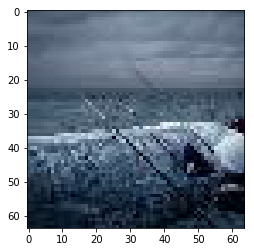

In [2]:
# Get train data paths and labels
# output : 4 lists - train_paths, train_labels, val_paths, val_labels
import pandas as pd

train_dir = '../data/tiny-imagenet-200/train/'
train_folders = os.listdir(train_dir)
train_paths, train_labels = [], []
label_dict = {}
for i, folder in enumerate(train_folders):
    label_dict[folder] = i
    paths = glob(os.path.join(train_dir, folder, 'images/*.JPEG'))
    train_paths += paths
    train_labels += [i]*len(paths)
print('Train data : ', len(train_paths), len(train_labels), max(train_labels), min(train_labels))
print(train_paths[:3], train_labels[:3])
print('\n')

# Get validation data paths and labels
val_dir = '../data/tiny-imagenet-200/val/images/'
val_paths = glob(val_dir + '*.JPEG')
df_annot = pd.read_csv('../data/tiny-imagenet-200/val/val_annotations.txt', \
                      header=None, sep='\t')
df_annot = df_annot.set_index(0)
val_labels = []
for path in val_paths:
    name = os.path.basename(path)
    folder = df_annot.loc[name].iloc[0]
    val_labels.append(label_dict[folder])
print('Validation data : ', len(val_paths), len(val_labels), max(val_labels), min(val_labels))
print(val_paths[:3], val_labels[:3])
print('\n')

# Display an image
img = cv2.imread(val_paths[1])
print(img.shape)
plt.imshow(img)
plt.show()

### Load Data: CIFAR-10

('Train data : ', 40000, 40000, 9, 0)
(['../data/cifar10/10605_4.jpg', '../data/cifar10/49670_9.jpg', '../data/cifar10/23787_6.jpg'], [4, 9, 6])


('Validation data : ', 10000, 10000, 9, 0)
(['../data/cifar10/7226_6.jpg', '../data/cifar10/49063_7.jpg', '../data/cifar10/40342_2.jpg'], [6, 7, 2])


(32, 32, 3)


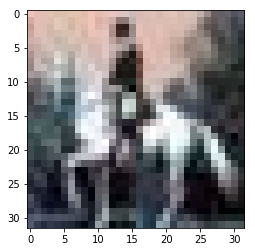

In [3]:
import numpy as np

src_dir = '../data/cifar10/'
img_paths = glob(src_dir + '*.jpg')
N = len(img_paths)

idx = np.arange(N)
np.random.shuffle(idx)
num_train = int(0.8*N)
train_paths = [img_paths[idx[i]] for i in range(num_train)]
val_paths = [img_paths[idx[num_train + i]] for i in range(N - num_train)]

train_labels = []
for path in train_paths:
    name = os.path.basename(path)
    train_labels.append(int(name[name.find('_')+1:-4]))
print('Train data : ', len(train_paths), len(train_labels), max(train_labels), min(train_labels))
print(train_paths[:3], train_labels[:3])
print('\n')


val_labels = []
for path in val_paths:
    name = os.path.basename(path)
    val_labels.append(int(name[name.find('_')+1:-4]))
print('Validation data : ', len(val_paths), len(val_labels), max(val_labels), min(val_labels))
print(val_paths[:3], val_labels[:3])
print('\n')

# Display an image
img = cv2.imread(val_paths[1])
print(img.shape)
plt.imshow(img)
plt.show()

### 2. Datagenerator and Iterator
- Create a tf.data object for both train and val data.  
- Add preprocessing and data augmentation.  
- Add iterators to get train and val batches.

Train iter
((64, 224, 224, 3), (64,))
Validation iter
((64, 224, 224, 3), (64,))


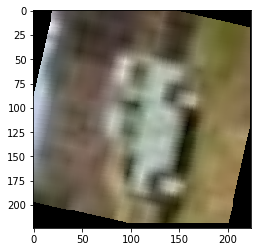

In [6]:
# Training pipeline including datagen, preprocessing and data aug

import numpy as np

batch_size = 64

# Preprocess data
def preprocess_data(path, label):
    img = tf.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize_images(img, [224, 224])
    img = img/255.0
    return img, label

# Augment data (translate and rotate)
def augment_data(img, label):
    img_tx = tf.contrib.image.rotate(img, \
            angles = tf.random_uniform(shape=[], minval=-10, maxval=10))
    img_tx = tf.contrib.image.translate(img_tx, \
            translations = [tf.random_uniform(shape=[], minval=-10, maxval=10), \
                           tf.random_uniform(shape=[], minval=-10, maxval=10)])
    return img_tx, label

train_paths = train_paths[:100]
train_labels = train_labels[:100]
val_paths = val_paths[:100]
val_labels = val_labels[:100]

# Create train dataset and iterator
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.map(preprocess_data, \
                      num_parallel_calls = \
                      tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(augment_data, \
                      num_parallel_calls = \
                      tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_iter = train_dataset.make_initializable_iterator()

# Create validation dataset and iterator (no shuffling and data augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(preprocess_data, \
                      num_parallel_calls = \
                      tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)
val_iter = val_dataset.make_initializable_iterator()

# Verify iterators
num_epochs = 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())        
    sess.run(train_iter.initializer)
    print('Train iter')
    while 1:
        try:
            x_train, y_train = sess.run(train_iter.get_next())
            print(x_train.shape, y_train.shape)
            break
        except tf.errors.OutOfRangeError:
            break

    # Validation
    sess.run(val_iter.initializer)
    print('Validation iter')
    while 1:
        try:
            x_val, y_val = sess.run(val_iter.get_next())
            print(x_val.shape, y_val.shape)
            break
        except tf.errors.OutOfRangeError:
            break

img = x_train[0]
plt.imshow(img)
plt.show()

### Define a model

In [12]:
def cnn(x):
    base_model = tf.keras.applications.inception_v3.InceptionV3(\
            input_shape = (224,224,3), include_top = False, weights = 'imagenet')
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(200)
    model = tf.keras.Sequential([
        base_model,
        global_average_layer,
        prediction_layer
    ])
    return model(x)
    
x = tf.placeholder(tf.float32, [None, 224, 224, 3])
y = tf.placeholder(tf.int32, [None])
y_pred = cnn(x)
loss = tf.reduce_mean(\
            tf.nn.sparse_softmax_cross_entropy_with_logits(\
            labels = y, logits = y_pred))
optimizer = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:
Use tf.cast instead.


### Train a model

In [5]:
import os
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7433688702982696257, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11710210080834701097
 physical_device_desc: "device: XLA_CPU device"]

In [7]:
from tqdm import tqdm

# Train and validate for several epochs
# Get summaries and display in tensorboard
num_epochs = 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(num_epochs):
        print('epoch = ', epoch)
        sess.run(train_iter.initializer)
        print('Training')
        itr = 0
        while 1:
            try:
                x_train, y_train = sess.run(train_iter.get_next())
                _, loss_val = sess.run([optimizer, loss], feed_dict = {x: x_train, y: y_train})
                print('Iteration = {}, Loss = {}'.format(itr, loss_val))
                itr += 1
            except tf.errors.OutOfRangeError:
                break

        # Validation
        sess.run(val_iter.initializer)
        print('Validation')
        loss_val = 0
        while 1:
            try:
                x_val, y_val = sess.run(val_iter.get_next())
                loss_val += sess.run([loss], feed_dict = {x: x_val, y: y_val})
            except tf.errors.OutOfRangeError:
                break
        print('Validation Loss = ', loss_val*batch_size/len(val_paths))


('epoch = ', 0)
Training


NameError: name 'optimizer' is not defined